# Advanced Regression Techniques

## Kaggle Score: 0.11694
## Kaggle Rank: 527
## Username: Anchal

## Importing the dataset 

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")
train_id=train_data["Id"]
test_id=test_data["Id"]
train_data=train_data.drop("Id",axis=1)
test_data=test_data.drop("Id",axis=1)

## Checking the distribution of the data

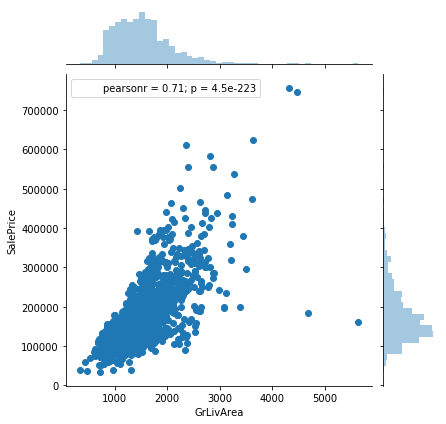

In [107]:
factor_cols=train_data.select_dtypes(include=['object']).columns
numeric_cols=train_data.select_dtypes(exclude=['object']).columns

sns.jointplot(x="GrLivArea", y='SalePrice', data=train_data)
plt.show()

#### Sale Price has a very high correlation with Living Area (as one would expect)

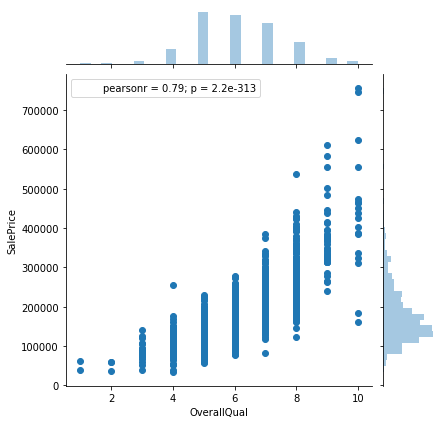

In [108]:
factor_cols=train_data.select_dtypes(include=['object']).columns
numeric_cols=train_data.select_dtypes(exclude=['object']).columns

sns.jointplot(x="OverallQual", y='SalePrice', data=train_data)
plt.show()

#### Price of a house increases as the overall quality of the house increase

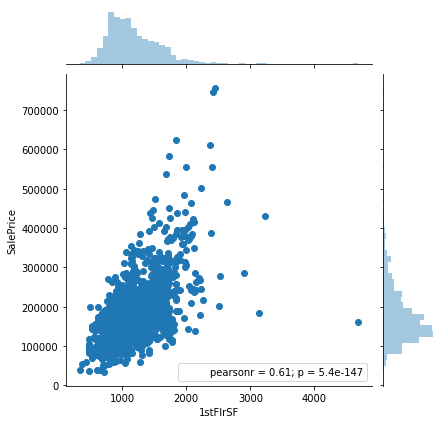

In [109]:
factor_cols=train_data.select_dtypes(include=['object']).columns
numeric_cols=train_data.select_dtypes(exclude=['object']).columns

sns.jointplot(x="1stFlrSF", y='SalePrice', data=train_data)
plt.show()

#### 1st Floor Surface area is also highly corelated with the Sale Price

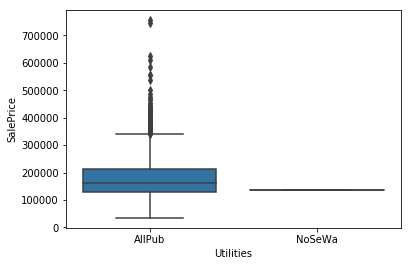

In [110]:
factor_cols=train_data.select_dtypes(include=['object']).columns
numeric_cols=train_data.select_dtypes(exclude=['object']).columns

sns.boxplot(x="Utilities", y='SalePrice', data=train_data)
plt.show()

### As we know that the one of the main properties of a good feature is that it should be discriminative; Utilities will not be helpful for us as this variable has only one value for almost the entire dataset. 

Therfore we will remove this feature in the later section

## Outliers: We see that some houses have very low Sale prices but have very high area so we remove these two data points from the data as they could negatively impact our model

In [111]:
outliers=train_data[(train_data.GrLivArea>4000) & (train_data.SalePrice<300000)].index
train_data=train_data.drop(outliers)


## Checking skewness in the target variable

1.8793604459195012


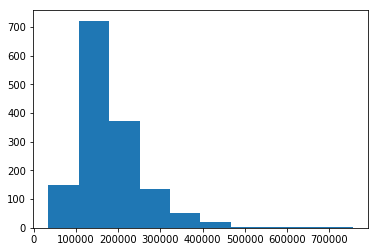

In [112]:
from scipy.stats import skew

skewness=skew(train_data["SalePrice"])
print(skewness)
plt.hist(train_data["SalePrice"])
plt.show()
#print(combined_data)

#### Sale Price is highly skewed so we transform it using log1p

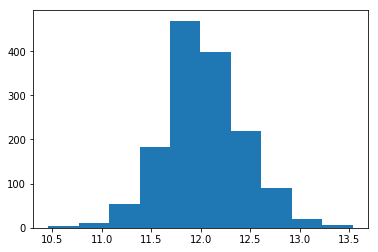

In [113]:
train_data["SalePrice"]=np.log1p(train_data["SalePrice"])
plt.hist(train_data["SalePrice"])
plt.show()

### The skewness seems to be corrected after the transformation

## Combining the train and test data: By combining the two datasets we ensure consistency in the features and reduce the amount of effort of working with train and test separately

In [114]:
y_train = train_data.SalePrice.values
combined = pd.concat((train_data, test_data)).reset_index(drop=True)
combined.drop(['SalePrice'], axis=1, inplace=True)

# Imputing the NA values

#### Checking which columns have null values

In [115]:
df_na=combined.isnull().sum()
print("There are",df_na[df_na!=0].count(),"columns with missing values listed below")
df_na[df_na!=0].sort_values(ascending=False)

There are 34 columns with missing values listed below


PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
dtype: int64

### For the null values in garage variables, most probably it means that there is no garage

But there are null values in 'Garage Type', 'Garage Condition', 'Garage Finish' and 'Garage Quality' when the Garage Area is not zero. This means that there is a garage but the type/qual/finish etc. is unknown so we impute these values by my the most frequent values in the same type of data points 

In [116]:
id1=combined[(combined['GarageArea']>0) & (combined['GarageYrBlt'].isnull())].index
print(combined.iloc[id1].GarageArea)

2124    360.0
Name: GarageArea, dtype: float64


#### The missing value has Garage Area = 360 so try to find the most occuring value of garage type/qual/finish etc. in the range (350,370)

In [117]:
df=combined[(combined['GarageArea']>350) & (combined['GarageArea']<370)]
print(df.GarageQual.mode())
print(df.GarageCond.mode())
print(df.GarageFinish.mode())
print(df.GarageType.mode())

0    TA
dtype: object
0    TA
dtype: object
0    Unf
dtype: object
0    Detchd
dtype: object


#### Now we impute the most occuring null values

In [118]:
combined.ix[id1,"GarageQual"]="TA"
combined.ix[id1,'GarageCond']="TA"
combined.ix[id1,'GarageFinish']="Unf"
combined.ix[id1,'GarageType']="Detchd"

/Users/anchaljaiswal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


### Masonry veneer type has one more null value (24) than Masonry veneer area (23) so we impute that missing value by the most frequent one for similar data points

Otherwise we believe that there is no Masonry for cases where there is a null value for Masonry area or type


In [119]:
id2=combined[(combined['MasVnrArea'].isnull()) & (combined['MasVnrType'].isnull())].index
id3=combined[(combined['MasVnrType'].isnull()) ].index
print(id2)
print(id3)

Int64Index([ 234,  528,  649,  935,  972,  976, 1242, 1277, 1689, 1704, 1880,
            1990, 2002, 2039, 2309, 2323, 2338, 2347, 2366, 2590, 2655, 2684,
            2860],
           dtype='int64')
Int64Index([ 234,  528,  649,  935,  972,  976, 1242, 1277, 1689, 1704, 1880,
            1990, 2002, 2039, 2309, 2323, 2338, 2347, 2366, 2590, 2608, 2655,
            2684, 2860],
           dtype='int64')


After examining the two indexes we notice that the missing index is 2608

In [120]:
## The missing index is 2608
index=2608
print(combined[combined['MasVnrArea']>0].MasVnrType.mode())

0    BrkFace
dtype: object


And the most common Masonry Type is "BrkFace" for houses that have positive Masonry area because zero area most probably means that there is no Masonry

In [121]:
combined.ix[index,"MasVnrType"]="BrkFace"

### More NA imputation that makes sense for the data:

We have described the intent for null imputation in comments below

In [122]:
## It makes sense to impute garage year built as exactly the same as year built (This is the same as what we did in class)
combined["GarageYrBlt"]=combined["GarageYrBlt"].fillna(combined["YearBuilt"])

## We impute the missing value for Lot Frontage by the median Lot Frontage of that neighbourhood
## Lot Frontage can be higghly dependent on the Neighbourhood therefore we choose to group by Neighbourhood and take
## the median value
combined["LotFrontage"] = combined.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

## Similarly we impute MSZoning based on MSSubClass
combined["MSZoning"] = combined.groupby("MSSubClass")["MSZoning"].transform(
    lambda x: x.fillna(x.mode()))

## Imputing MSZoning by the most occuring value in the dataset because it has only 4 missing values
combined["MSZoning"]=combined["MSZoning"].fillna(combined["MSZoning"].mode(), inplace=True)

## We drop Utilities as most of the rows have the same value for Utilities so this will not help 
## in the prediction for the algorithm
combined=combined.drop("Utilities",axis=1)

## We impute the null values for exterior covering on the house as Other
combined['Exterior1st']=combined['Exterior1st'].fillna("Other")
combined['Exterior2nd']=combined['Exterior2nd'].fillna("Other")


## NA in PoolQC means that there is no pool. We can confirm this by looking at the plot between Pool Area and 
## Sale Price above
combined["PoolQC"] = combined["PoolQC"].fillna("None")

## NA in MiscFeature means that there are no miscellaneous features
combined["MiscFeature"] = combined["MiscFeature"].fillna("None")

## NA in Alley means that there is no Alley access 

combined["Alley"] = combined["Alley"].fillna("None")

## NA in Fence means that there is no Fence
combined["Fence"] = combined["Fence"].fillna("None")

## NA in FireplaceQu means that there is no FirePlace
combined["FireplaceQu"] =combined["FireplaceQu"].fillna("None")

## We impute None for garage columns
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    combined[col] = combined[col].fillna('None')

## We impute zero for numerical garage cols as they gave the best result
for col in ('GarageArea', 'GarageCars'):
    combined[col] = combined[col].fillna(0)

## We impute median for numerical basement cols as they gave the best result
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    combined[col] = combined[col].fillna(combined[col].median())

## We impute None for bsmt columns 
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    combined[col] = combined[col].fillna('None')

## We impute None for MasVnr columns
combined["MasVnrType"] = combined["MasVnrType"].fillna("None")

# We impute Zero/None for Masvnr columns
combined["MasVnrArea"] = combined["MasVnrArea"].fillna(0)

## We impute MSSubClass with the mode
combined['MSSubClass'] = combined['MSSubClass'].fillna(combined["MSSubClass"].mode)

In [77]:
## For Functional, SaleType, KitchenQual, Electrical, MSZoning we impute the most frequent value because these 
## have very low number of NA values
print(combined['Functional'].mode())
print(combined["SaleType"].mode())
print(combined["KitchenQual"].mode())
print(combined["Electrical"].mode())
print(combined["MSZoning"].mode())


0    Typ
dtype: object
0    WD
dtype: object
0    TA
dtype: object
0    SBrkr
dtype: object
Series([], dtype: object)


#### We impute the null values with the mode computed above

In [123]:
combined["MSZoning"].fillna("RL", inplace=True)
combined['Functional'].fillna("Typ",inplace=True)
combined["SaleType"].fillna("WD", inplace=True)
combined["KitchenQual"].fillna("TA", inplace=True)
combined["Electrical"].fillna("SBrkr", inplace=True)

## Now we check if there are any more NA values

In [124]:
df_na=combined.isnull().sum()
print("There are",df_na[df_na!=0].count(),"columns with missing values listed below")
df_na[df_na!=0].sort_values(ascending=False)

There are 0 columns with missing values listed below


Series([], dtype: int64)

### Now we don't have any NA values


## Some variables are actually categorical but in the dataset it says that they are numerical

So we convert them into string as treating them as numerical will negatively impact our model

In [125]:
combined["MSSubClass"] = combined["MSSubClass"].astype(str)
combined["MSZoning"] = combined["MSZoning"].astype(str)
combined["LotConfig"] = combined["LotConfig"].astype(str)
combined["Neighborhood"] = combined["Neighborhood"].astype(str)
combined["Condition1"] = combined["Condition1"].astype(str)
combined["BldgType"] = combined["BldgType"].astype(str)
combined["HouseStyle"] = combined["HouseStyle"].astype(str)
combined["RoofStyle"] = combined["RoofStyle"].astype(str)
combined["Exterior1st"] = combined["Exterior1st"].astype(str)
combined["Exterior2nd"] = combined["Exterior2nd"].astype(str)
combined["MasVnrType"] = combined["MasVnrType"].astype(str)
combined["Foundation"] = combined["Foundation"].astype(str)
combined["SaleType"] = combined["SaleType"].astype(str)
combined["SaleCondition"] = combined["SaleCondition"].astype(str)




## We create more variables based on our unersatnding and taking some inspiration from Kaggle kernels:

We have described the intent of creating these variables in the comments below. This was one of the most important step in the assignment asit really boosted our performance

In [126]:
## Combining Overall Condition and Quality 
combined['Total_Home_Quality'] = combined['OverallQual'] + combined['OverallCond']

## Combining Basement Condition and Quality 
combined['Total_Basement_Quality'] = combined['BsmtQual'] + combined['BsmtCond']

## Combining Surface area for Basement
combined['Total_Basement_FinshedSqFt'] = combined['BsmtFinSF1'] + combined['BsmtFinSF2']

## Combining Exterior Condition and Quality 
combined['Total_Exterior_Quality'] = combined['ExterQual'] + combined['ExterCond']

## Combining Garage Condition, Finish and Quality 
combined['Total_Garage_Quality'] = combined['GarageCond'] + combined['GarageQual'] + combined['GarageFinish']

## Combining Basement Finish Type 
combined['Total_Basement_FinshType'] = combined['BsmtFinType1'] + combined['BsmtFinType2']

## Combining Garage Condition and Quality 
combined['Total_Garage_Quality'] = combined['GarageCond'] + combined['GarageQual'] + combined['GarageFinish']

## Combining Basement finish type
combined['Total_Basement_FinshType'] = combined['BsmtFinType1'] + combined['BsmtFinType2']

## Combining area for bathrooms (taking 0.5 factor for half baths)
combined['Total_Bathrooms'] = combined['BsmtFullBath'] + (combined['BsmtHalfBath'] * 0.5) + combined['FullBath'] + (combined['HalfBath'] * 0.5)

## Combining Land quality variables
combined['Total_Land_Quality'] = combined['LandSlope'] + combined['LotShape']



## Create a variable to distinguish specific features from the others 
## Creating these variables was very help ful as it boosted the score significantly
combined["IsRegularLotShape"] = (combined["LotShape"] == "Reg") *1
combined["IIsLandLevel"] = (combined["LandContour"] == "Lvl") * 1
combined["IsLandSlopeGentle"] = (combined["LandSlope"] == "Gtl") * 1
combined["IsElectricalSBrkr"] = (combined["Electrical"] == "SBrkr") * 1
combined["IsGarageDetached"] = (combined["GarageType"] == "Detchd") * 1
combined["IsPavedDrive"] = (combined["PavedDrive"] == "Y") * 1
combined["HasShed"] = (combined["MiscFeature"] == "Shed") * 1
combined["Remodeled"] = (combined["YearRemodAdd"] != combined["YearBuilt"]) * 1
combined["RecentRemodel"] = (combined["YearRemodAdd"] == combined["YrSold"]) * 1
combined["VeryNewHouse"] = (combined["YearBuilt"] == combined["YrSold"]) * 1
combined["Has2ndFloor"] = (combined["2ndFlrSF"] == 0) * 1
combined["HasMasVnr"] = (combined["MasVnrArea"] == 0) * 1
combined["HasWoodDeck"] = (combined["WoodDeckSF"] == 0) * 1
combined["HasOpenPorch"] = (combined["OpenPorchSF"] == 0) * 1
combined["HasEnclosedPorch"] = (combined["EnclosedPorch"] == 0) * 1
combined["Has3SsnPorch"] = (combined["3SsnPorch"] == 0) * 1
combined["HasScreenPorch"] = (combined["ScreenPorch"] == 0) * 1

#Drop the individual components from above to avoid multicolinearity

combined.drop("OverallQual", axis = 1, inplace = True)
combined.drop("OverallCond", axis = 1, inplace = True)
combined.drop("BsmtQual", axis = 1, inplace = True)
combined.drop("BsmtCond", axis = 1, inplace = True)
combined.drop("BsmtFinSF1", axis = 1, inplace = True)
combined.drop("BsmtFinSF2", axis = 1, inplace = True)
combined.drop("ExterQual", axis = 1, inplace = True)
combined.drop("ExterCond", axis = 1, inplace = True)
combined.drop("GarageCond", axis = 1, inplace = True)
combined.drop("GarageQual", axis = 1, inplace = True)
combined.drop("GarageFinish", axis = 1, inplace = True)
combined.drop("BsmtFinType1", axis = 1, inplace = True)
combined.drop("BsmtFinType2", axis = 1, inplace = True)
combined.drop("BsmtFullBath", axis = 1, inplace = True)
combined.drop("BsmtHalfBath", axis = 1, inplace = True)
combined.drop("FullBath", axis = 1, inplace = True)
combined.drop("HalfBath", axis = 1, inplace = True)
combined.drop("LandSlope", axis = 1, inplace = True)
combined.drop("LotShape", axis = 1, inplace = True)



### Label encoding some variables instead of creating dummies because these might contain information in an ordered way:

If we treat them as dummy we are telling our algorithm that the difference between any two levels of a feature is same which is not correct. For example comparing Overall Quality=2 and Overal Quality 10 would be different then comparing Quality=1 and Quality=10

In [127]:
combined = combined.replace({"BsmtCond" : {"None" : 0,"No":0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "None":0,"Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"None" : 0,"No":0,"Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"None" : 0,"No":0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"None" : 0, "No":0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0,"No":0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"None" : 0, "No":0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageFinish" : {"None" : 0,"No":0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
                       "GarageQual" : {"None" : 0, "No":0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )


## We remove skewness from explanatory variables by using the Box Cox transformation. I also tried log1p from numpy but this gave me a slightly better result

In [128]:
from scipy.special import boxcox1p
import numpy as np


factor_cols=combined.select_dtypes(include=['object','category']).columns
numeric_cols=combined.select_dtypes(exclude=['object','category']).columns

skewness=combined[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = skewness[abs(skewness) > .75]
sk_feat=skewness.index
for i in sk_feat:
    
    combined[[i]] = boxcox1p(combined[i],.15)
  


### Unlike R in Python we need to create dummy variables for the categorical features

In [129]:
combined_data = pd.get_dummies(combined.reset_index(drop=True))

### Now we split the combined dataset into train and test to run the algorithms

In [142]:
train = combined_data[:1458]
test = combined_data[1458:]


### Importing all the libraries needed in this chunk

In [143]:
from sklearn import linear_model
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import sklearn.feature_selection as Fselector


### Found this cross validation function online that shuffles your dataset before splitting

In [144]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Full Model

In [145]:
lm=linear_model.LinearRegression()
score=rmsle_cv(lm)
print("RMSLE is ",score.mean())

RMSLE is  0.175996385005


## Using Mutual Information to filter out some features

In [138]:
M=Fselector.mutual_info_regression(train, y_train,discrete_features='auto', n_neighbors=3, copy=True, random_state=None)

In [140]:
M=np.array(M)
total_features=M.shape[0]
train = combined_data[:1458]
j=0
count=0
#train.values=train.drop("SalePrice",axis=1)
M_features=[]
for i in range(total_features):
    if((M[i])<.01):
        M_features.append(i)
        j=j+1
train_minfo=train.drop(train.columns[M_features],axis=1)
#train_minfo=train_minfo.drop("SalePrice",axis=1)


train=train_minfo


lm=linear_model.LinearRegression()


score=rmsle_cv(lm)
print("RMSLE is ",score.mean())

RMSLE is  0.118413946355


### We notice that this reduces the RMSE on the full model BUT when we run Lasso/ Ridge with the filtered variables this gives a worse result so I end up not using this function

### I also tried F-regression but it had the same problem

## Lasso Regression: We also use Robust Scaler to make it robust against outliers

#### We plot RMSE with alpha values to pick the best value for our model

/Users/anchaljaiswal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/anchaljaiswal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/anchaljaiswal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/anchaljaiswal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: Converge

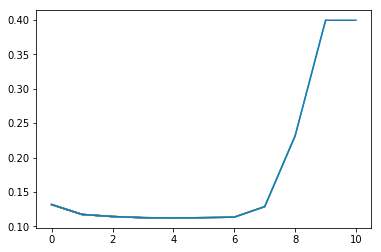

In [197]:
alphas=[1e-6,1e-4,2e-4,4e-4,6e-4,8e-4,1e-3,1e-2,1e-1,1,10]
score=[]
for i in alphas:
    lassoreg = make_pipeline(RobustScaler(), Lasso(alpha=i))
    c=rmsle_cv(lassoreg)
    score.append(c.mean())
    plt.plot(score)
plt.show()

3rd Value i.e 0.0004 looks good for the model so lets use that

In [198]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =.0004))
score = rmsle_cv(lasso)
print("\nLasso score: {:.6f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.112701 (0.0051)



## Elastic Nets: This is a combination of L1 and L2 regularization. I am using L1_Ratio as 0.8 as this gave me the best results

#### Checking the different alpha models 

/Users/anchaljaiswal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/anchaljaiswal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/anchaljaiswal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/anchaljaiswal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: Converge

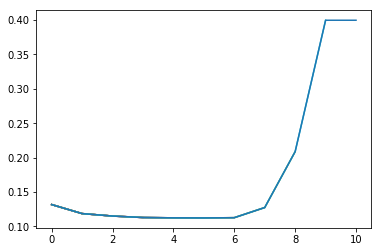

In [200]:
alphas=[1e-6,1e-4,2e-4,4e-4,6e-4,8e-4,1e-3,1e-2,1e-1,1,10]
score=[]
for i in alphas:
    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=i, l1_ratio=.8, random_state=3))
    c=rmsle_cv(ENet)
    score.append(c.mean())
    plt.plot(score)
plt.show()

3rd Value i.e 0.0004 looks good for the model so lets use that for Elastic Nets as well

In [202]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0004, l1_ratio=.8, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.6f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.112968 (0.0050)



## Ridge Regression

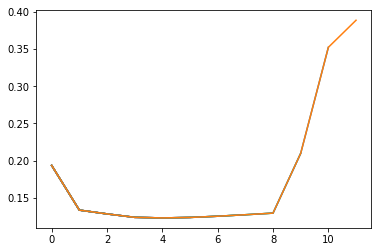

In [205]:
alphas=[1e-6,1e-4,1e-2,1e-1,2e-1,4e-1,6e-1,8e-1,1,10,100,500]
score=[]
for i in alphas:
    ridgereg = make_pipeline(RobustScaler(),Ridge(alpha=i,normalize=True))
    c=rmsle_cv(ridgereg)
    score.append(c.mean())
    plt.plot(score)
plt.show()

5th point i.e 2e-1 looks a ggood option for Ridge regression so we go ahead and use it in the model

In [152]:
ridgereg = make_pipeline(RobustScaler(),Ridge(alpha=0.2,normalize=True))
score=rmsle_cv(ridgereg)
print(score.mean())

0.122985034092


## Bootstrapping on the Lasso model :

We use all the features and use max_sample as 0.5. Ideally this should be fine tuned but this simple imputation for parameters gave a decent result

In [153]:
from sklearn.ensemble import BaggingRegressor
bg=BaggingRegressor(lasso, n_estimators=100, max_samples=0.5, max_features=1.0, bootstrap=True)

s=rmsle_cv(bg)
s.mean()

0.11252433933139536

## Bootstrapping on Elastic Nets: 

We use the same parameters for Elastic Nets as well

In [206]:
from sklearn.ensemble import BaggingRegressor
bg1=BaggingRegressor(ENet, n_estimators=100, max_samples=0.5, max_features=1.0, bootstrap=True)

s=rmsle_cv(bg1)
s.mean()

0.1120993025151393

### Found this function on Kaggle to average simple models:

A simple averaging really helped boost our score on Kaggle. There are other advanced techniques including ensembles and stacking but we don't explore them yet as they are complex and in our understanding it makes more sense to do a stacking when you are combining different types of models like tree-based models with linear models

In [207]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

In [208]:
averaged_models = AveragingModels(models = (bg1, bg))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.6f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.112423 (0.0052)



### Getting the prediction values

In [209]:
averaged_models.fit(train.values, y_train)
stacked_train_pred = averaged_models.predict(train.values)
stacked_pred = np.expm1(averaged_models.predict(test.values))

**Submission**

In [210]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = stacked_pred
sub.to_csv('Kaggle1.csv',index=False)

## End of code